In [17]:
from jupyter_dash import JupyterDash
from dash import Dash, html, dcc, Input, Output, State
import plotly.graph_objs as go
import pandas as pd
from datetime import datetime, timedelta
import boto3
from boto3.dynamodb.conditions import Key
import pandas as pd
import requests
import plotly.express as px
from io import StringIO
import os
import time
from dotenv import load_dotenv

load_dotenv()

True

In [12]:
# Initialize Dash app
# app = dash.Dash(__name__)
# server = app.server

# AWS configuration 
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
AWS_REGION = 'us-east-1'


In [13]:
dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('crypto-prices')

In [16]:
def get_data(table, time1, time2):
    try:
        response = table.query(
            KeyConditionExpression =Key('PK').eq('CRYPTO_PRICES') &
                                    Key('timestamp').between(
                                        time1,
                                        time2
                                        )
                                    )
        df = pd.DataFrame(response['Items']).drop(columns=['ttl', 'PK'])

        return df
    
    except Exception as e:
        raise Exception(f'qQuery failed: {e}')


In [160]:
df = get_data(table, '2025-10-13T16:00:00', '2025-10-16T11:00:00')
options = ['dogecoin', 'tron', 'bitcoin']
selection = df.loc[:, options]
print(selection)

     dogecoin      tron bitcoin
0    0.182245  0.277479   99400
1    0.181916  0.277444   99110
2    0.181516  0.277501   98994
3     0.18149  0.277292   99031
4    0.182571  0.277334   99128
..        ...       ...     ...
289  0.170015  0.276375   95382
290  0.169983  0.276569   95324
291  0.170975  0.276927   95549
292  0.170897   0.27719   95575
293  0.171221  0.277295   95747

[294 rows x 3 columns]


In [106]:
base_url = "https://api.gdeltproject.org/api/v2/doc/doc"

# using proximity
personality = "Trump"
crypto_keywords = ["bitcoin"]
newspapers = ["wsj.com", "ft.com", "nytimes.com", "bloomberg.com", "coindesk.com"]
proximity = 15  # number of words between personality and crypto keyword

# Build domain filter
domain_filters = " OR ".join([f"domainis:{d}" for d in newspapers])

# Build crypto keyword part
if len(crypto_keywords) > 1:
    crypto_keywords_ = ' OR '.join(crypto_keywords)
else:
    crypto_keywords_ = crypto_keywords[0]

# Build nearX query for each crypto keyword
# e.g., near5:"Trump Bitcoin" OR near5:"Trump Ethereum"
near_queries = ' OR '.join([f'near{proximity}:"{personality} {c}"' for c in crypto_keywords_ .split(' OR ')])

# Combine with domains and language
if len(crypto_keywords) > 1:
    full_query = f"({near_queries}) sourcelang:English ({domain_filters})"
else:
    full_query = f"{near_queries} sourcelang:English ({domain_filters})"



params = {
    "query": full_query,  
    "mode": "artlist",
    "format": "csv",
    "startdatetime": "20251013000000",
    "enddatetime": "20251016235959",
    "sort" : "datedesc",
    "maxrecords": 250
}

response = requests.get(base_url, params=params)
# data_dict = response.json()
csv_data = StringIO(response.text)

# Read CSV into a DataFrame
df_news = pd.read_csv(csv_data)

In [107]:
df_news['person'] = ['Trump', 'Musk']
df_news['Date'] = pd.to_datetime(df_news['Date']).dt.round('1s')
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.round('1s')

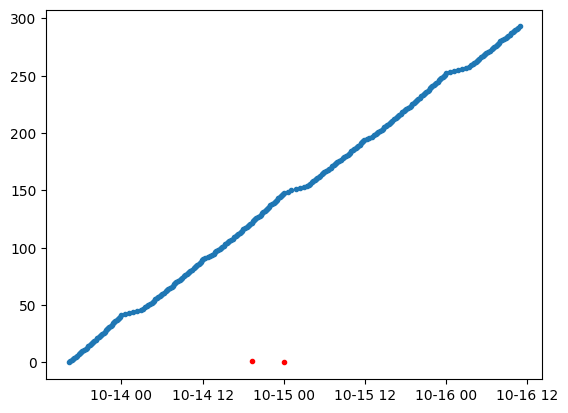

In [108]:
import matplotlib.pyplot as plt

plt.plot(df['timestamp'], list(range(0,len(df['timestamp']))), '.')
plt.plot(df_news['Date'], list(range(0,len(df_news['Date']))), 'r.')

In [162]:
time_range

240004657.14699998

In [129]:


CRYPTO_COLORS = {
    'bitcoin': '#F7931A',        # Orange
    'ethereum': '#627EEA',       # Blue/Purple
    'tether': '#26A17B',         # Green
    'binancecoin': '#F3BA2F',    # Yellow/Gold
    'solana': '#14F195',         # Bright Green/Cyan
    'ripple': '#23292F',         # Dark Gray/Black
    'cardano': '#0033AD',        # Blue
    'dogecoin': '#C2A633',       # Gold/Yellow
    'tron': '#FF060A',           # Red
    'usd-coin': '#2775CA',       # Blue
}

import base64

def img_to_base64(path):
    with open(path, "rb") as f:
        return "data:image/jpeg;base64," + base64.b64encode(f.read()).decode()

IMAGE_PATHS = {
    'trump': img_to_base64('./images/round/trump.png'),
    'elon': img_to_base64('./images/round/elon.png')
}

# IMAGE_PATHS = {
#     'trump': './images/raw/trump.jpg',
#     'elon': './images/raw/elon.jpg'
# }

traces = []
for crypto in selection.columns:
    traces.append(go.Scatter(
        x=pd.to_datetime(df['timestamp']).dt.round('1s'),              # ← Use this if timestamps are in index
        y=df[crypto],            # ← Crypto column name
        mode='lines',
        name=crypto,
        line=dict(color=CRYPTO_COLORS.get(crypto, '#FFFFFF'), width=3),
        marker=dict(size=4)
    ))

fig = go.Figure(data=traces)

y_min = float(df[selection.columns].min().min())
y_max = float(df[selection.columns].max().max())
image_y = y_min + (y_max - y_min) * 0.02  

# --- Add each news image as overlay marker ---
for i, row in df_news.iterrows():
    date = pd.to_datetime(row['Date'])
    
    # Calculate width as a fraction of the total time range
    time_range = (pd.to_datetime(df['timestamp']).max() - pd.to_datetime(df['timestamp']).min()).total_seconds() * 1000
    image_width = time_range * 0.2  # 5% of total time range (increased from 2%)
    
    fig.add_layout_image(
        dict(
            source=IMAGE_PATHS['trump'] if row['person'].lower() == 'trump' else IMAGE_PATHS['elon'],
            x=date,
            y=image_y,
            xref="x",
            yref="y",
            sizex=image_width,
            sizey=(y_max - y_min) * 0.1,  # 15% of chart height (increased from 8%)
            xanchor="center",
            yanchor="middle",
            layer="above"
        )
    )

fig.add_trace(go.Scatter(
    x=pd.to_datetime(df_news['Date']),
    y=[image_y] * len(df_news),
    mode='markers',
    marker=dict(
        size=50,  # Large enough to cover the image area
        opacity=0,  # Invisible
        color='rgba(0,0,0,0)'
    ),
    hovertext=df_news['Title'],
    hoverinfo='text',
    name='News Events',
    showlegend=False
))

fig.update_layout(
    title='Crypto Prices with News Events',
    template='plotly_dark',
    paper_bgcolor='#1E1E1E',
    plot_bgcolor='#2D2D2D',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price (USD)'),
    height=600
)

fig.show()

In [170]:
CRYPTO_COLORS = {
    'bitcoin': '#F7931A',        # Orange
    'ethereum': '#627EEA',       # Blue/Purple
    'tether': '#26A17B',         # Green
    'binancecoin': '#F3BA2F',    # Yellow/Gold
    'solana': '#14F195',         # Bright Green/Cyan
    'ripple': '#23292F',         # Dark Gray/Black
    'cardano': '#0033AD',        # Blue
    'dogecoin': '#C2A633',       # Gold/Yellow
    'tron': '#FF060A',           # Red
    'usd-coin': '#2775CA',       # Blue
}

import base64

def img_to_base64(path):
    with open(path, "rb") as f:
        return "data:image/jpeg;base64," + base64.b64encode(f.read()).decode()

IMAGE_PATHS = {
    'trump': img_to_base64('./images/round/trump.png'),
    'elon': img_to_base64('./images/round/elon.png')
}

traces = []
for crypto in selection.columns:
    traces.append(go.Scatter(
        x=pd.to_datetime(df['timestamp']).dt.round('1s'),
        y=df[crypto],
        mode='lines',
        name=crypto,
        line=dict(color=CRYPTO_COLORS.get(crypto, '#FFFFFF'), width=3),
        marker=dict(size=4)
    ))

fig = go.Figure(data=traces)

y_min = float(df[selection.columns].min().min())
y_max = float(df[selection.columns].max().max())
image_y = y_max + (y_max - y_min) * 0.05


# --- Add each news image as overlay marker ---
for i, row in df_news.iterrows():
    date = pd.to_datetime(row['Date'])
    
    # Make date timezone-aware to match df timestamps
    if date.tz is None:
        date = date.tz_localize('UTC')
    
    # Calculate width as a fraction of the total time range
    time_range = (pd.to_datetime(df['timestamp']).max() - pd.to_datetime(df['timestamp']).min()).total_seconds() * 1000
    image_width = time_range * 0.5
    
    fig.add_layout_image(
        dict(
            source=IMAGE_PATHS['trump'] if row['person'].lower() == 'trump' else IMAGE_PATHS['elon'],
            x=date,
            y=image_y,
            xref="x",
            yref="y",
            sizex=image_width,
            sizey=(y_max - y_min) * 0.1,
            xanchor="center",
            yanchor="middle",
            layer="above"
        )
    )
    
    # Find the closest timestamp in the crypto data
    df_temp = df.copy()
    df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
    closest_idx = (df_temp['timestamp'] - date).abs().idxmin()
    
    # Get prices at that timestamp for all selected cryptos
    for crypto in selection.columns:
        crypto_price = df.loc[closest_idx, crypto]
        
        # Add dashed line from image to price
        fig.add_trace(go.Scatter(
            x=[date, date],
            y=[image_y, crypto_price],
            mode='lines',
            line=dict(color='white', width=1, dash='dash'),
            showlegend=False,
            hoverinfo='skip'
        ))
        
        # Add point at the intersection with the price line
        fig.add_trace(go.Scatter(
            x=[date],
            y=[crypto_price],
            mode='markers',
            marker=dict(
                size=8,
                color=CRYPTO_COLORS.get(crypto, '#FFFFFF'),
                line=dict(color='white', width=2)
            ),
            showlegend=False,
            hovertext=f"{crypto}: ${crypto_price:.2f}<br>{row['Title']}",
            hoverinfo='text'
        ))

# Add invisible scatter points for hover text over images
fig.add_trace(go.Scatter(
    x=pd.to_datetime(df_news['Date']).dt.tz_localize('UTC') if pd.to_datetime(df_news['Date']).dt.tz is None else pd.to_datetime(df_news['Date']),
    y=[image_y] * len(df_news),
    mode='markers',
    marker=dict(
        size=50,
        opacity=0,
        color='rgba(0,0,0,0)'
    ),
    hovertext=df_news['Title'],
    hoverinfo='text',
    name='News Events',
    showlegend=False
))

fig.update_layout(
    title='Crypto Prices with News Events',
    template='plotly_dark',
    paper_bgcolor='#1E1E1E',
    plot_bgcolor='#2D2D2D',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price (USD)'),
    height=600,
    hovermode='closest'
)

# Set initial view to last 24 hours
latest_date = pd.to_datetime(df['timestamp']).max()
initial_start = latest_date - pd.Timedelta(hours=24)

fig.update_xaxes(
    rangeslider_visible=True,
    range=[latest_date - pd.Timedelta(hours=24), latest_date]
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeslider_thickness=0.1,
    rangeselector=dict(
        buttons=[
            dict(count=1, label="1H", step="hour", stepmode="backward"),
            # dict(count=6, label="6H", step="hour", stepmode="backward"),
            # dict(count=12, label="12H", step="hour", stepmode="backward"),
            dict(count=1, label="1D", step="day", stepmode="backward"),
            dict(count=3, label="3D", step="day", stepmode="backward"),
            dict(step="all", label="All")
        ],
        bgcolor="#2D2D2D",              # Dark background for buttons
        activecolor="#4D4D4D",          # Lighter dark when selected
        bordercolor="#FFFFFF",          # White border
        borderwidth=1,
        font=dict(color="#FFFFFF")      # White text
    )
)

fig.show()

In [97]:
uri = pil_to_base64_uri("./images/round/trump.jpg")
print(uri[:100])  

data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAIAAAACACAYAAADDPmHLAABoS0lEQVR4nN29CbSl6XUVtv95vOObX8


In [5]:
def get_Options(df):
    keys = [key.capitalize() for key in df.keys() if key != 'timestamp']
    options = []
    for key in keys:
        cur_dict = {'label': key, 'value':key.lower()}
        options.append(cur_dict)
    
    return options

options = get_Options(df) 


NameError: name 'df' is not defined

In [7]:
app = Dash(__name__)

CRYPTO_COLORS = {
    'bitcoin': '#F7931A',        # Orange
    'ethereum': '#627EEA',       # Blue/Purple
    'tether': '#26A17B',         # Green
    'binancecoin': '#F3BA2F',    # Yellow/Gold
    'solana': '#14F195',         # Bright Green/Cyan
    'ripple': '#23292F',         # Dark Gray/Black
    'cardano': '#0033AD',        # Blue
    'dogecoin': '#C2A633',       # Gold/Yellow
    'tron': '#FF060A',           # Red
    'usd-coin': '#2775CA',       # Blue
}

app.layout = html.Div([
    html.H1('Crypto Dashboard', style={'color': '#FFF', 'textAlign': 'center'}),
    
    # Hidden component to store data
    dcc.Store(id='crypto-data-store'),
    
    html.Div([
        html.Label('Select Cryptos to Display:', style={'color': '#FFF', 'fontWeight': 'bold'}),
        dcc.Checklist(
            id='crypto-selector',
            options=[{'label': 'Tether', 'value': 'tether'},
                    {'label': 'Ethereum', 'value': 'ethereum'},
                    {'label': 'Binancecoin', 'value': 'binancecoin'},
                    {'label': 'Cardano', 'value': 'cardano'},
                    {'label': 'Dogecoin', 'value': 'dogecoin'},
                    {'label': 'Solana', 'value': 'solana'},
                    {'label': 'Tron', 'value': 'tron'},
                    {'label': 'Ripple', 'value': 'ripple'},
                    {'label': 'Usd-coin', 'value': 'usd-coin'},
                    {'label': 'Bitcoin', 'value': 'bitcoin'}],
            value=['bitcoin'],
            inline=False,
            style={'color': '#FFF', 'padding': '10px'}
        ),
    ], style={'padding': '20px', 'backgroundColor': '#2D2D2D', 'margin': '20px', 'borderRadius': '10px'}),
    
    html.Div([
        html.Label('Start Time:', style={'color': '#FFF', 'marginRight': '10px'}),
        dcc.Input(
            id='start_time',
            value='2025-10-13T16:00', 
            type='datetime-local',
            style={'padding': '8px'}
        ),
        
        html.Label('End Time:', style={'color': '#FFF', 'marginRight': '10px', 'marginLeft': '20px'}),
        dcc.Input(
            id='end_time',
            value='2025-10-14T16:00', 
            type='datetime-local',
            style={'padding': '8px'}
        ),
    ], style={'padding': '20px', 'backgroundColor': '#2D2D2D', 'margin': '20px', 'borderRadius': '10px'}),
    
    html.Div(id='query-status', style={'color': '#FFD700', 'padding': '10px', 'textAlign': 'center'}),
    
    dcc.Graph(id='chart')
], style={'backgroundColor': '#121212', 'minHeight': '100vh'})

# CALLBACK 1: Query database and store data (only triggers on time change)
@app.callback(
    [Output('crypto-data-store', 'data'),
     Output('query-status', 'children')],
    [Input('start_time', 'value'),
     Input('end_time', 'value')]
)
def query_database(start_time, end_time):
    """This runs only when time changes - queries database"""
    print(f"QUERYING DATABASE: {start_time} to {end_time}")
    
    # Query ALL cryptos from database
    df_all = get_data(table, start_time, end_time)
    
    # Convert to JSON for storage
    data_json = df_all.to_json(date_format='iso', orient='split')
    
    status = f"Loaded {len(df_all)} records from database"
    
    return data_json, status

# CALLBACK 2: Update chart display (triggers on crypto selection OR when data changes)
@app.callback(
    Output('chart', 'figure'),
    [Input('crypto-data-store', 'data'),    # Triggers when data is loaded
     Input('crypto-selector', 'value')]     # Triggers when selection changes
)
def update_chart(stored_data, selected_cryptos):
    """This runs when crypto selection changes - uses stored data, NO new query"""
    
    if not stored_data:
        return {
            'data': [],
            'layout': go.Layout(
                title='Waiting for data...',
                template='plotly_dark',
                paper_bgcolor='#1E1E1E',
                plot_bgcolor='#2D2D2D'
            )
        }
    
    print(f"UPDATING CHART (no query): Showing {selected_cryptos}")
    
    # Load data from storage (no database query!)
    df = pd.read_json(stored_data, orient='split')
    
    # Filter by selected cryptos
    traces = []
    for crypto in selected_cryptos:
        if len(df) == 0:
            continue
        
        traces.append(go.Scatter(
            x=df['timestamp'],
            y=df[crypto],
            mode='lines+markers',
            name=crypto,
            line=dict(color=CRYPTO_COLORS.get(crypto, '#FFFFFF'), width=3),
            marker=dict(size=4)
        ))

    return {
        'data': traces,
        'layout': go.Layout(
            title=f'Crypto Prices - Displaying {len(selected_cryptos)} cryptos',
            template='plotly_dark',
            paper_bgcolor='#1E1E1E',
            plot_bgcolor='#2D2D2D',
            xaxis={'title': 'Time'},
            yaxis={'title': 'Price (USD)'},
            hovermode='x unified'
        )
    }

import threading

def run_dash():
    app.run(debug=False, port=8050, use_reloader=False)

thread = threading.Thread(target=run_dash, daemon=True)
thread.start()

print("Dashboard running at: http://127.0.0.1:8050")

Dashboard running at: http://127.0.0.1:8050


In [ ]:

app = Dash(__name__)



CRYPTO_COLORS = {
    'bitcoin': '#F7931A',        # Orange
    'ethereum': '#627EEA',       # Blue/Purple
    'tether': "#6F9C8D",         # Green
    'binancecoin': '#F3BA2F',    # Yellow/Gold
    'solana': '#14F195',         # Bright Green/Cyan
    'ripple': "#C51CDF",         # Dark Gray/Black
    'cardano': '#0033AD',        # Blue
    'dogecoin': '#C2A633',       # Gold/Yellow
    'tron': '#FF060A',           # Red
    'usd-coin': '#2775CA',       # Blue
}

app.layout = html.Div([
    html.H1('Crypto Dashboard', style={'color': '#FFF', 'textAlign': 'center'}),
    
    dcc.RadioItems(
        id='crypto-selector',
        options=get_Options(df),
        value=['BIT'],
        inline=False,
        style={'color': '#FFF', 'padding': '20px'}
    ),
    
    dcc.Input(
        id='start_time',
        value='2025-10-13T16:00:00', 
        type='text'
    ),

    dcc.Input(
        id='end_time',
        value='2025-10-14T16:00:00', 
        type='text'
    ),

    # dcc.RadioItems(
    #     id='timeframe',
    #     options=[
    #         {'label': ' 7d', 'value': '7'},
    #         {'label': ' 30d', 'value': '30'}
    #     ],
    #     value='7',
    #     inline=True,
    #     style={'color': '#FFF', 'padding': '20px'}
    # ),
    
    dcc.Graph(id='chart')
], style={'backgroundColor': '#121212', 'minHeight': '100vh'})

@app.callback(
    Output('chart', 'figure'),
    [Input('crypto-selector', 'value'),
     Input('timeframe', 'value')]
)
def update_chart(cryptos, days):
    traces = []
    for crypto in cryptos:
        df = get_mock_data(crypto, int(days))
        traces.append(go.Scatter(
            x=df['date'],
            y=df['price'],
            mode='lines+markers',
            name=crypto,
            line=dict(color=CRYPTO_COLORS[crypto], width=3)
        ))
    
    return {
        'data': traces,
        'layout': go.Layout(
            template='plotly_dark',
            paper_bgcolor='#1E1E1E',
            plot_bgcolor='#2D2D2D'
        )
    }

# Run in a thread for notebooks
import threading

def run_dash():
    app.run(debug=False, port=8050, use_reloader=False)

thread = threading.Thread(target=run_dash, daemon=True)
thread.start()

print("Dashboard running at: http://127.0.0.1:8050")

Dashboard running at: http://127.0.0.1:8050


🔍 QUERYING DATABASE: 2025-10-13T16:00 to 2025-10-14T16:00🔍 QUERYING DATABASE: 2025-10-13T01:00 to 2025-10-14T16:00
🔍 QUERYING DATABASE: 2025-10-13T16:00 to 2025-10-14T16:00
🔍 QUERYING DATABASE: 2025-10-13T18:00 to 2025-10-14T16:00



[2025-10-14 16:32:54,018] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/davide/miniconda3/envs/prefect_env/lib/python3.11/site-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/davide/miniconda3/envs/prefect_env/lib/python3.11/site-packages/flask/app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/davide/miniconda3/envs/prefect_env/lib/python3.11/site-packages/flask/app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/davide/miniconda3/envs/prefect_env/lib/python3.11/site-packages/flask/app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [48]:


app = JupyterDash(__name__)

# Define color palette for different cryptos
CRYPTO_COLORS = {
    'BTC': '#F7931A',
    'ETH': '#627EEA',
    'SOL': '#00FFA3',
    'ADA': '#0033AD',
    'DOT': '#E6007A'
}

# App layout
app.layout = html.Div([
    html.Div([
        html.H1('Interactive Crypto Dashboard', 
                style={'color': '#FFFFFF', 'marginBottom': '10px'}),
        html.P('Select cryptocurrencies and timeframe to compare price trends',
               style={'color': '#B0B0B0', 'fontSize': '16px'})
    ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': '#1E1E1E'}),
    
    html.Div([
        # Controls Row
        html.Div([
            # Crypto Selection
            html.Div([
                html.Label('Select Cryptocurrencies to Overlay:', 
                          style={'color': '#FFFFFF', 'fontWeight': 'bold', 'marginBottom': '10px'}),
                dcc.Checklist(
                    id='crypto-selector',
                    options=[
                        {'label': ' Bitcoin (BTC)', 'value': 'BTC'},
                        {'label': ' Ethereum (ETH)', 'value': 'ETH'},
                        {'label': ' Solana (SOL)', 'value': 'SOL'},
                        {'label': ' Cardano (ADA)', 'value': 'ADA'},
                        {'label': ' Polkadot (DOT)', 'value': 'DOT'}
                    ],
                    value=['BTC', 'ETH'],  # Default selections
                    inline=True,
                    style={'color': '#FFFFFF'},
                    labelStyle={'marginRight': '20px', 'marginBottom': '10px'}
                )
            ], style={'marginBottom': '20px'}),
            
            # Timeframe Selection
            html.Div([
                html.Div([
                    html.Label('Quick Timeframe:', 
                              style={'color': '#FFFFFF', 'fontWeight': 'bold', 'marginBottom': '10px'}),
                    dcc.RadioItems(
                        id='timeframe-selector',
                        options=[
                            {'label': ' 7 Days', 'value': '7'},
                            {'label': ' 30 Days', 'value': '30'},
                            {'label': ' 90 Days', 'value': '90'},
                            {'label': ' Custom', 'value': 'custom'}
                        ],
                        value='7',
                        inline=True,
                        style={'color': '#FFFFFF'},
                        labelStyle={'marginRight': '20px'}
                    )
                ], style={'width': '100%', 'marginBottom': '15px'}),
                
                # Custom Date Range (hidden by default)
                html.Div([
                    html.Label('Custom Date Range:', 
                              style={'color': '#FFFFFF', 'fontWeight': 'bold', 'marginBottom': '10px'}),
                    dcc.DatePickerRange(
                        id='date-picker',
                        start_date=(datetime.now() - timedelta(days=30)).date(),
                        end_date=datetime.now().date(),
                        display_format='YYYY-MM-DD',
                        style={'marginTop': '10px'}
                    )
                ], id='date-picker-container', style={'display': 'none'})
            ])
        ], style={'backgroundColor': '#2D2D2D', 'padding': '20px', 'borderRadius': '10px', 'marginBottom': '20px'}),
    ])
])

app.run_server(mode='external', port=8050)

AttributeError: 'super' object has no attribute 'run_server'

In [ ]:
app.layout = html.Div([
    html.Div([
            # Publication year trend
            html.Div([
                dcc.Graph(
                    figure=px.line(
                        book_data.groupby('publication_year').size().reset_index(name='count'),
                        x='publication_year', 
                        y='count',
                        title='Books by Publication Year',
                        labels={'count': 'Number of Books', 'publication_year': 'Year'}
                    ).update_layout(height=400)
                )
            ], style={'width': '50%', 'display': 'inline-block'})
        ])
    ])

,tether,ethereum,binancecoin,cardano,dogecoin,solana,tron,ripple,usd-coin,bitcoin,timestamp
0,0.864732,3593.78,1109.34,0.620478,0.182245,170.24,0.277479,2.24,0.863804,99400,2025-10-13T16:11:14.869496+00:00
1,0.864693,3595.99,1108.51,0.616431,0.181916,171.11,0.277444,2.24,0.863591,99110,2025-10-13T16:27:35.479438+00:00
2,0.865189,3588.58,1106.27,0.617337,0.181516,172.21,0.277501,2.23,0.864147,98994,2025-10-13T16:41:57.621896+00:00
3,0.864757,3596.14,1105.54,0.615812,0.18149,171.58,0.277292,2.23,0.863806,99031,2025-10-13T16:52:47.604888+00:00
4,0.864816,3602.74,1107.84,0.61914,0.182571,173.19,0.277334,2.24,0.863815,99128,2025-10-13T17:03:09.475261+00:00
...,...,...,...,...,...,...,...,...,...,...,...
85,0.866865,3442.11,1034.53,0.586241,0.172299,169.7,0.269121,2.12,0.865843,96379,2025-10-14T11:11:25.513994+00:00
86,0.866616,3443.71,1030.31,0.5867,0.17271,169.6,0.269006,2.13,0.865576,96563,2025-10-14T11:23:53.673851+00:00
87,0.866311,3440.84,1025.47,0.586533,0.172723,169.5,0.268734,2.13,0.865273,96571,2025-10-14T11:34:06.024064+00:00
88,0.866358,3442.29,1017.7,0.587644,0.1727,169.41,0.269553,2.13,0.865305,96486,2025-10-14T11:43:34.246441+00:00


In [ ]:


# Calculate summary metrics
book_data['publisher'] = book_data['publisher'].apply(lambda x: x[:20] + "..." if len(x) > 20 else x)
book_data['primary_category'] = book_data['primary_category'].str.lower().apply(lambda x: x[:20] + "..." if len(x) > 20 else x)
total_books = len(book_data)
ratings_count = book_data['ratings_count'].sum()
avg_rating = book_data['avg_rating'].mean()
if book_data['publication_year'].max() > datetime.now().year:
    latest_year = datetime.now().year
else:
    latest_year = book_data['publication_year'].max()

# Category distribution with "Other" grouping
category_counts = book_data['primary_category'].value_counts()
filtered_df = category_counts[category_counts >= len(book_data) * 0.02].reset_index()
filtered_df.columns = ['primary_category', 'count']

# Dashboard layout
app.layout = html.Div([
    # Header
    html.Div([
        html.H1("Book Analytics Dashboard", 
                style={'text-align': 'center', 'color': '#2c3e50', 'margin-bottom': '30px'})
    ]),

    # Overview section
    html.Div([
        html.P(
            "This dashboard provides summary statistics and visualizations "
            "for the collection of books sourced from Google Books and made "
            "available to the Book Recommender. "
            "Here, you can explore how many books are included, along with "
            "insights into publication trends, ratings distribution, and "
            "category breakdowns.",
            style={
                'textAlign': 'center',
                'color': '#2c3e50',
                'marginTop': '40px',
                'marginBottom': '40px',
                'fontSize': '16px',
                'lineHeight': '1.6'
            }
        )
    ]),
    
    # Summary cards
    html.Div([
        html.Div([
            html.H3(f"{total_books:,}", style={'margin': '0', 'color': '#3498db'}),
            html.P("Total Books", style={'margin': '5px 0'})
        ], className='summary-card'),
        
        html.Div([
            html.H3(f"{avg_rating:.1f}", style={'margin': '0', 'color': '#e74c3c'}),
            html.P("Average Rating", style={'margin': '5px 0'})
        ], className='summary-card'),
        
        html.Div([
            html.H3(f"{latest_year}", style={'margin': '0', 'color': '#27ae60'}),
            html.P("Latest Publication", style={'margin': '5px 0'})
        ], className='summary-card')
    ], style={'display': 'flex', 'justify-content': 'space-around', 'margin-bottom': '30px'}),
    
    # Charts section
    html.Div([
        # Publication year trend
        html.Div([
            dcc.Graph(
                figure=px.line(
                    book_data.groupby('publication_year').size().reset_index(name='count'),
                    x='publication_year', 
                    y='count',
                    title='Books by Publication Year',
                    labels={'count': 'Number of Books', 'publication_year': 'Year'}
                ).update_layout(height=400)
            )
        ], style={'width': '50%', 'display': 'inline-block'}),
        
        # Top publishers
        html.Div([
            dcc.Graph(
                figure=px.bar(
                    book_data['publisher'].value_counts().head(8).reset_index(),
                    x='count', 
                    y='publisher',
                    orientation='h',
                    title='Top Publishers',
                    labels={'count': 'Number of Books', 'publisher': 'Publisher'}
                ).update_layout(height=400)
            )
        ], style={'width': '50%', 'display': 'inline-block'})
    ]),
    
    html.Div([
        # Category distribution
        html.Div([
            dcc.Graph(
                figure=px.pie(
                    filtered_df,
                    values='count',
                    names='primary_category',
                    title='Books by Category'
                ).update_layout(height=400)
            )
        ], style={'width': '50%', 'display': 'inline-block'}),
        
        # Rating distribution
        html.Div([
            dcc.Graph(
                figure=px.histogram(
                    book_data,
                    x='avg_rating',
                    nbins=10,
                    title='Rating Distribution',
                    labels={'avg_rating': 'Average Rating', 'count': 'Number of Books'}
                ).update_layout(height=400)
            )
        ], style={'width': '50%', 'display': 'inline-block'})
    ]),
    
    # Data table
    html.Div([
        html.H3("Book Details", style={'margin-top': '30px'}),
        dash_table.DataTable(
            data=book_data.head(5).to_dict('records'),
            columns=[
                {'name': 'Title', 'id': 'title'},
                {'name': 'Author', 'id': 'primary_author'},
                {'name': 'Publisher', 'id': 'publisher'},
                {'name': 'Year', 'id': 'publication_year'},
                {'name': 'Rating', 'id': 'avg_rating', 'type': 'numeric', 'format': {'specifier': '.1f'}},
                {'name': 'Ratings Count', 'id': 'ratings_count', 'type': 'numeric', 'format': {'specifier': 'd'}},
                {'name': 'Category', 'id': 'primary_category'}
            ],
            style_cell={'textAlign': 'left', 'padding': '10px'},
            style_header={'backgroundColor': '#3498db', 'color': 'white', 'fontWeight': 'bold'},
            style_data_conditional=[
                {
                    'if': {'filter_query': '{avg_rating} > 4'},
                    'backgroundColor': '#d5f4e6',
                }
            ]
        )
    ])
], style={'max-width': '1200px', 'margin': '0 auto', 'padding': '20px'})

# Add CSS styling
app.index_string = '''
<!DOCTYPE html>
<html>
    <head>
        {%metas%}
        <title>{%title%}</title>
        {%favicon%}
        {%css%}
        <style>
            .summary-card {
                background: white;
                padding: 20px;
                border-radius: 8px;
                box-shadow: 0 2px 10px rgba(0,0,0,0.1);
                text-align: center;
                width: 200px;
            }
            body {
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                background-color: #f8f9fa;
                margin: 0;
            }
        </style>
    </head>
    <body>
        {%app_entry%}
        <footer>
            {%config%}
            {%scripts%}
            {%renderer%}
        </footer>
    </body>
</html>
'''

if __name__ == '__main__':
    app.run(debug=True)